## Importing the Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from keras.utils import pad_sequences
from keras_preprocessing.text import Tokenizer
from keras import Sequential
from keras.layers import Embedding, MaxPooling1D, Flatten, Dense, Conv1D, Dropout

## Importing variables from the preprocessing notebook as csv files


In [2]:
y = np.loadtxt('y.csv', delimiter=',')
X = pd.read_csv('X.csv')

In [3]:
X

,Unnamed: 0,preprocessed_text
0,0,total bill horrible service crook actually ner...
1,1,adore travis hard rock new kelly cardenas salo...
2,2,say office really together organized friendly ...
3,3,went lunch steak sandwich delicious caesar sal...
4,4,today second three session paid for although f...
...,...,...
8923,9995,quite sci airport kiosk check go past border c...
8924,9996,family went new year eve dad birthday dinner p...
8925,9997,im comment conduct one tour leader taking grou...
8926,9998,it like many buffet started promising kind sta...


In [4]:
# Explore the distribution of sequence lengths
sequence_lengths = X['preprocessed_text'].apply(lambda x: len(x.split()))

# Calculate the 95th percentile
percentile_95 = np.percentile(sequence_lengths, 95)

# Set max_length slightly higher than the 95th percentile
max_length = int(percentile_95 * 1.1)

print("Chosen Max Length:", max_length)

Chosen Max Length: 167


In [5]:
# Build a vocabulary from your text data
all_text = ' '.join(X['preprocessed_text'].tolist())
unique_words = set(all_text.split())
vocab_size = len(unique_words) + 1  # Add 1 for an out-of-vocabulary token

print("Vocabulary Size:", vocab_size)

Vocabulary Size: 24810


## CNN Model

In [6]:
X = X['preprocessed_text']
X = [str(x) for x in X]

# Tokenize and pad sequences
vocab_size = 24810
max_len = 167

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
X = pad_sequences(sequences, maxlen=max_len)
y = np.array(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Set embedding dimension, and maximum sequence length
embedding_dim = 50

# Create a Sequential model
model = Sequential()

# Add Embedding layer
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))

# Add Convolutional layers
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Flatten layer
model.add(Flatten())

# Add Fully Connected layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(1, activation='sigmoid'))

In [8]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 167, 50)           1240500   
                                                                 
 conv1d (Conv1D)             (None, 163, 64)           16064     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 81, 64)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 5184)              0         
                                                                 
 dense (Dense)               (None, 64)                331840    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                        

In [10]:
# Train the model and store the history
history_cnn = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
179/179 [==============================] - 17s 71ms/step - loss: 0.4083 - accuracy: 0.8176 - val_loss: 0.1926 - val_accuracy: 0.9223
Epoch 2/10
179/179 [==============================] - 10s 53ms/step - loss: 0.1149 - accuracy: 0.9604 - val_loss: 0.1716 - val_accuracy: 0.9328
Epoch 3/10
179/179 [==============================] - 5s 27ms/step - loss: 0.0308 - accuracy: 0.9930 - val_loss: 0.2403 - val_accuracy: 0.9265
Epoch 4/10
179/179 [==============================] - 7s 39ms/step - loss: 0.0083 - accuracy: 0.9979 - val_loss: 0.3035 - val_accuracy: 0.9202
Epoch 5/10
179/179 [==============================] - 8s 42ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.3527 - val_accuracy: 0.9230
Epoch 6/10
179/179 [==============================] - 10s 58ms/step - loss: 9.4688e-04 - accuracy: 1.0000 - val_loss: 0.3990 - val_accuracy: 0.9216
Epoch 7/10
179/179 [==============================] - 7s 37ms/step - loss: 6.8403e-04 - accuracy: 1.0000 - val_loss: 0.4244 - val_accur

## Model Evaluation on Training and Validation Data

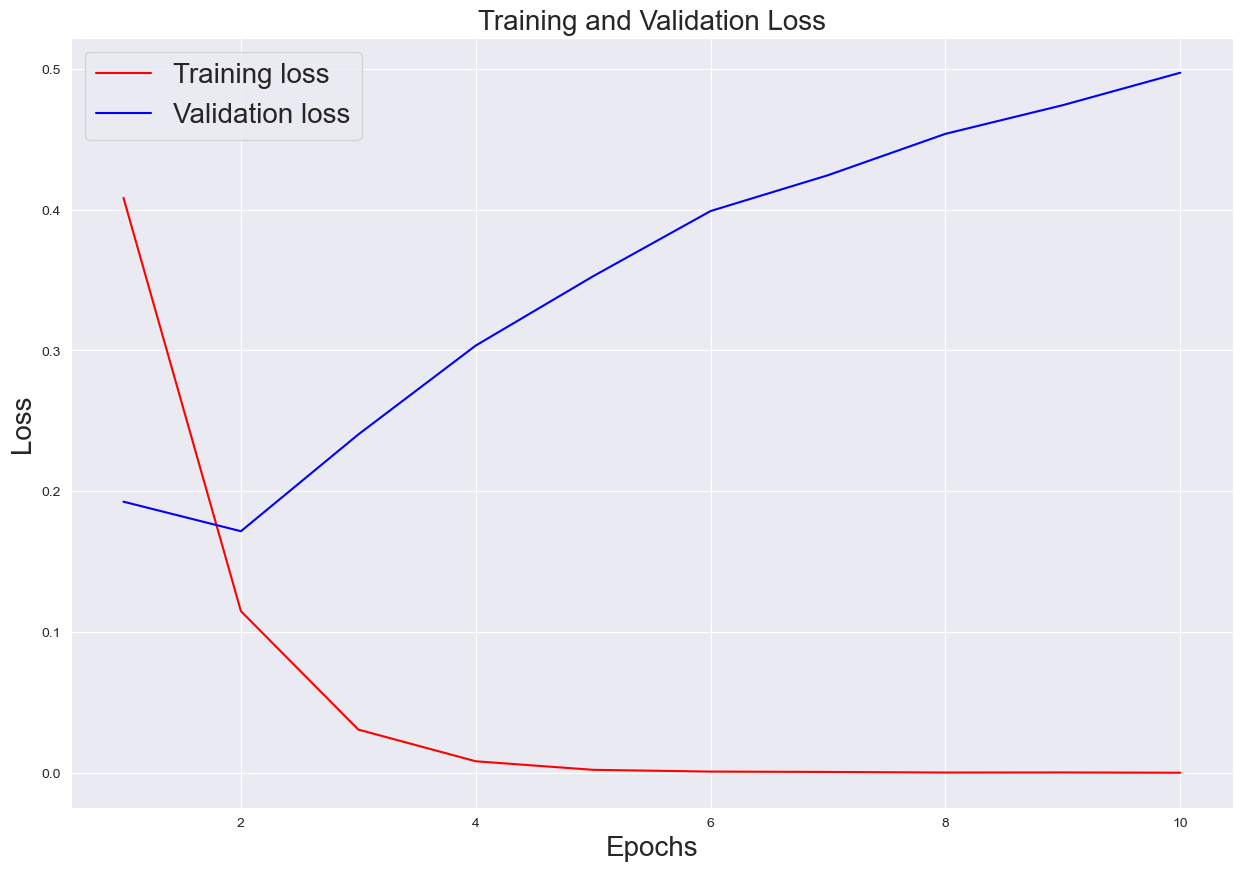

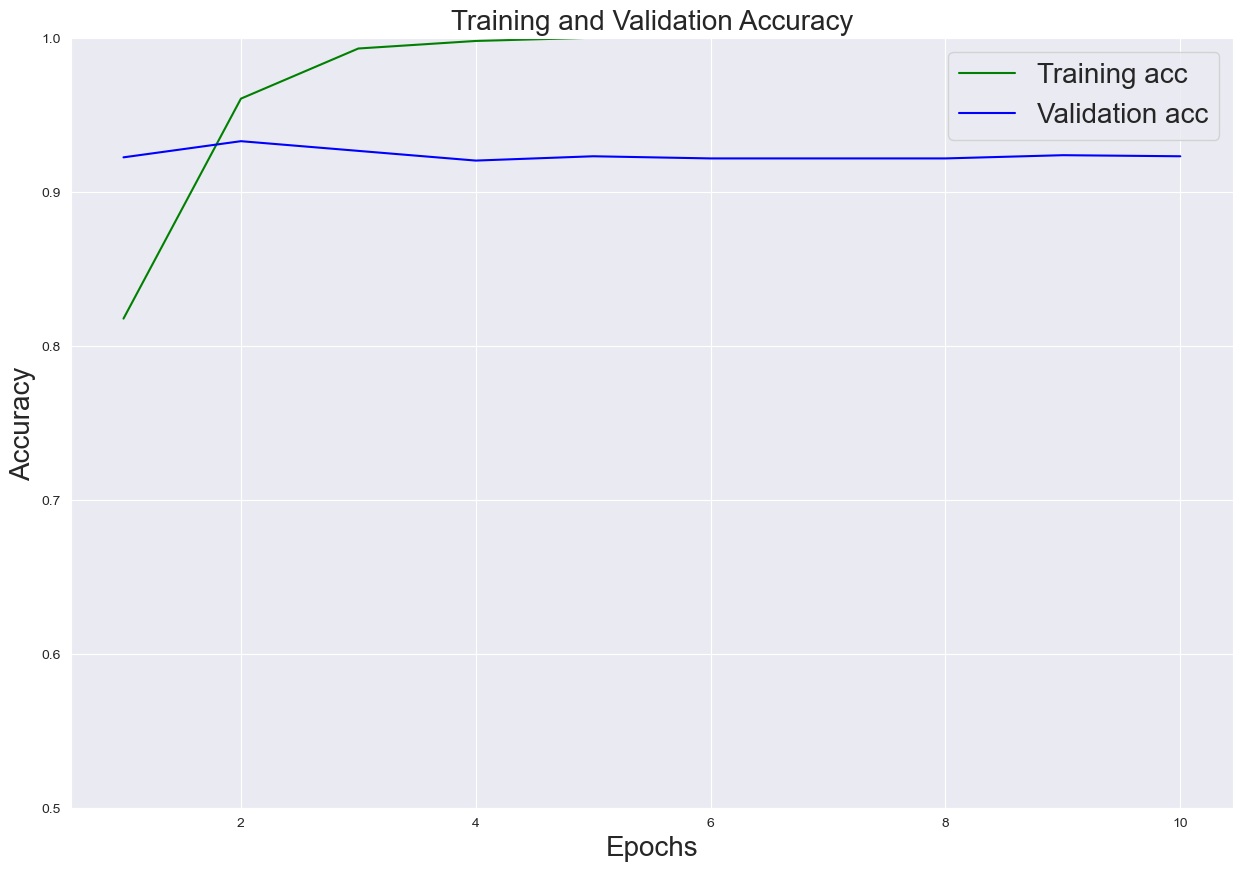

In [11]:
# Extract training history
history_cnn_dict = history_cnn.history

# Extract metrics
acc_cnn = history_cnn_dict['accuracy']
val_acc_cnn = history_cnn_dict['val_accuracy']
loss_cnn = history_cnn_dict['loss']
val_loss_cnn = history_cnn_dict['val_loss']
epochs_cnn = range(1, len(acc_cnn) + 1)

# Plot training and validation loss
plt.figure(figsize=(15, 10))
plt.plot(epochs_cnn, loss_cnn, 'r', label='Training loss')
plt.plot(epochs_cnn, val_loss_cnn, 'b', label='Validation loss')
plt.title('Training and Validation Loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(15, 10))
plt.plot(epochs_cnn, acc_cnn, 'g', label='Training acc')
plt.plot(epochs_cnn, val_acc_cnn, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

## Model Evaluation on Test Data

In [12]:
# Evaluate the model on the test data
evaluation = model.evaluate(X_test, y_test)

# Extract the evaluation metrics (e.g., loss and accuracy)
loss, accuracy = evaluation

56/56 [==============================] - 2s 43ms/step - loss: 0.5303 - accuracy: 0.9166


In [13]:
# Get model predictions on the test data
y_pred_probs  = model.predict(X_test)

# Apply a threshold to convert probabilities to binary predictions
threshold = 0.5
y_pred = (y_pred_probs > threshold).astype(int)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

56/56 [==============================] - 2s 18ms/step
Loss: 0.5302618145942688
Accuracy: 0.9165733456611633
Precision: 0.93717277486911
Recall: 0.9506828528072838
F1-Score: 0.9438794726930321


## Classification Report

In [14]:
# Generate the classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.82      0.84       468
         1.0       0.94      0.95      0.94      1318

    accuracy                           0.92      1786
   macro avg       0.90      0.89      0.89      1786
weighted avg       0.92      0.92      0.92      1786



## Confusion Matrix

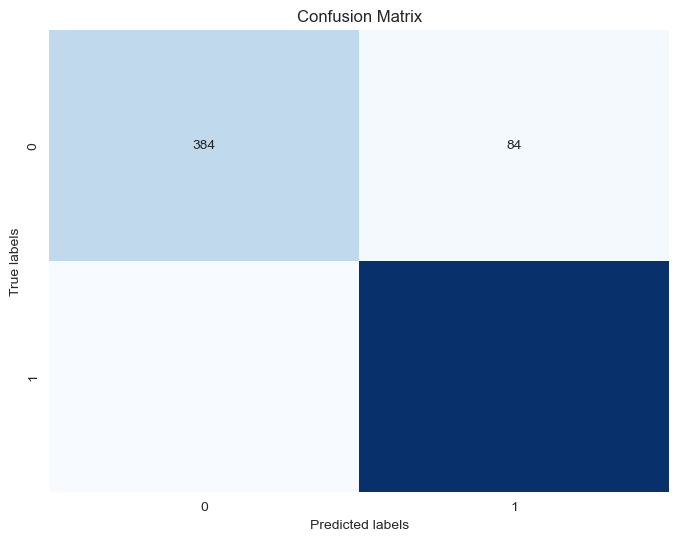

In [15]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()